In [1]:
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt

from time import time
from functools import partial

# from sklearn.datasets import fetch_20newsgroups

from optparse import OptionParser
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.utils.extmath import density

In [2]:
%matplotlib inline

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

In [4]:
def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

In [5]:
op = OptionParser()

op.add_option("--report",
              action="store_true", dest="print_report", default=True,
              help="Print a detailed classification report.")

op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")

op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")

op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class for every classifier.")

op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")

op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")

In [6]:
# work-around for Jupyter notebook and IPython console

# opts, an object containing values for all of your options
#     e.g. if --file takes a single string argument, then options.file will be the filename supplied by the user, 
#     or None if the user did not supply that option
# args, the list of positional arguments leftover after parsing options

argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
opts

<Values at 0x7fb77c187a00: {'print_report': True, 'select_chi2': None, 'print_cm': None, 'print_top10': None, 'all_categories': None, 'use_hashing': None, 'n_features': 65536, 'filtered': None}>

In [7]:
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



# Data

## load

In [8]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

In [ ]:
# TODO:

data_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42, remove=remove)
data_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42, remove=remove)
print('data loaded')

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names

print(type(data_train))
print(type(data_train.data))
print(len(data_train.data))
print()
print(data_train.data[0])
print(set(y_train))
target_names

In [12]:
data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))
print()

2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories



## feature

In [13]:
print("Extracting features from the training data using a sparse vectorizer")

t0 = time()


if opts.use_hashing:
    # TODO: 
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False, n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
    
    
duration = time() - t0

print('use hash: [%s]'  % opts.use_hashing)
print()

print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

Extracting features from the training data using a sparse vectorizer
use hash: [None]

done in 0.564602s at 7.048MB/s
n_samples: 2034, n_features: 33809



In [14]:
print("Extracting features from the test data using the same vectorizer")

t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0

print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

Extracting features from the test data using the same vectorizer
done in 0.294045s at 9.752MB/s
n_samples: 1353, n_features: 33809



In [15]:
# mapping from integer feature name to original token string

if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

feature_names[-10:]

['zwakke',
 'zware',
 'zwarte',
 'zxmkr08',
 'zyeh',
 'zyklon',
 'zyxel',
 'ªl',
 'º_________________________________________________º_____________________º',
 'ºnd']

In [16]:
# get_support(indices=False)
# Get a mask, or integer index, of the features selected
#
# indicesbool, default=False
# If True, the return value will be an array of integers, rather than a boolean mask.

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" % opts.select_chi2)
    
    t0 = time()
    
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    
    if feature_names: feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
        
    print("done in %fs" % (time() - t0))
    print()

In [17]:
if feature_names: feature_names = np.asarray(feature_names)

# Classify

In [18]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [19]:
def fit(clf, X_train, y_train):
    
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    
    return train_time

In [20]:
def predict(clf, X_test):
    
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    return pred, test_time

In [21]:
def accuracy(y_test, pred):
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    return score

In [22]:
def print_coef(clf, opts, feature_names, target_names):
    # TODO:
    
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

In [23]:
def print_report(opts, y_test, pred, target_names):
    
    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=target_names))

In [24]:
def print_cm(opts, y_test, pred):
    
    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

In [25]:
def get_desc(clf):
    return str(clf).split('(')[0]

In [26]:
def __benchmark(X_train, y_train, X_test, y_test, opts, feature_names, target_names, clf):
    
    train_time = fit(clf, X_train, y_train)
    pred, test_time = predict(clf, X_test)
    score = accuracy(y_test, pred)
    clf_descr = get_desc(clf)

    print_coef(clf, opts, feature_names, target_names)
    print_report(opts, y_test, pred, target_names)
    print_cm(opts, y_test, pred)
    print()
    
    return clf_descr, score, train_time, test_time

In [27]:
benchmark = partial(__benchmark, X_train, y_train, X_test, y_test, opts, feature_names, target_names)

## score

In [28]:
results = []

In [29]:
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.187s
test time:  0.002s
accuracy:   0.898
dimensionality: 33809
density: 1.000000

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.90      0.98      0.94       389
         sci.space       0.95      0.95      0.95       394
talk.religion.misc       0.83      0.78      0.80       251

          accuracy                           0.90      1353
         macro avg       0.89      0.88      0.89      1353
      weighted avg       0.90      0.90      0.90      1353


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)


/home/wangyh/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 0.036s
test time:  0.004s
accuracy:   0.888
dimensionality: 33809
density: 0.255302

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.86      0.80      0.83       319
     comp.graphics       0.90      0.97      0.94       389
         sci.space       0.95      0.93      0.94       394
talk.religion.misc       0.79      0.80      0.79       251

          accuracy                           0.89      1353
         macro avg       0.88      0.88      0.88      1353
      weighted avg       0.89      0.89      0.89      1353


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
train time: 0.033s
test time:  0.004s
accuracy:   0.901
dimensionality: 33809
density: 0.685372

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.86      0.84      0.85       319
   

In [30]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50, penalty=penalty)))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
train time: 0.113s
test time:  0.002s
accuracy:   0.900
dimensionality: 33809
density: 1.000000

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.91      0.98      0.95       389
         sci.space       0.96      0.95      0.95       394
talk.religion.misc       0.83      0.79      0.81       251

          accuracy                           0.90      1353
         macro avg       0.89      0.89      0.89      1353
      weighted avg       0.90      0.90      0.90      1353


________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50)
train time: 0.036s
test time:  0.002s
accuracy:   0.899
dimensionality: 33809
density: 0.588445

classification report:
                    p

In [31]:
# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50, penalty="elasticnet")))

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(max_iter=50, penalty='elasticnet')
train time: 0.164s
test time:  0.002s
accuracy:   0.901
dimensionality: 33809
density: 0.185528

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.92      0.98      0.95       389
         sci.space       0.95      0.95      0.95       394
talk.religion.misc       0.82      0.80      0.81       251

          accuracy                           0.90      1353
         macro avg       0.89      0.89      0.89      1353
      weighted avg       0.90      0.90      0.90      1353




In [32]:
# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid()
train time: 0.008s
test time:  0.003s
accuracy:   0.855
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.88      0.69      0.77       319
     comp.graphics       0.84      0.97      0.90       389
         sci.space       0.96      0.92      0.94       394
talk.religion.misc       0.72      0.79      0.75       251

          accuracy                           0.86      1353
         macro avg       0.85      0.84      0.84      1353
      weighted avg       0.86      0.86      0.85      1353




In [33]:
# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01)
train time: 0.011s
test time:  0.002s
accuracy:   0.899
dimensionality: 33809
density: 1.000000

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.85      0.87      0.86       319
     comp.graphics       0.95      0.95      0.95       389
         sci.space       0.92      0.95      0.94       394
talk.religion.misc       0.86      0.77      0.81       251

          accuracy                           0.90      1353
         macro avg       0.89      0.89      0.89      1353
      weighted avg       0.90      0.90      0.90      1353


________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01)
train time: 0.009s
test time:  0.008s
accuracy:   0.884
dimensionality: 33809
density: 1.000000

classification report:
                    precision 

In [34]:
print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])
train time: 0.246s
test time:  0.003s
accuracy:   0.878
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.84      0.79      0.81       319
     comp.graphics       0.91      0.96      0.93       389
         sci.space       0.93      0.95      0.94       394
talk.religion.misc       0.79      0.75      0.77       251

          accuracy                           0.88      1353
         macro avg       0.87      0.86      0.86      1353
      weighted avg       0.88      0.88      0.88      1353




## efficiency

In [35]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

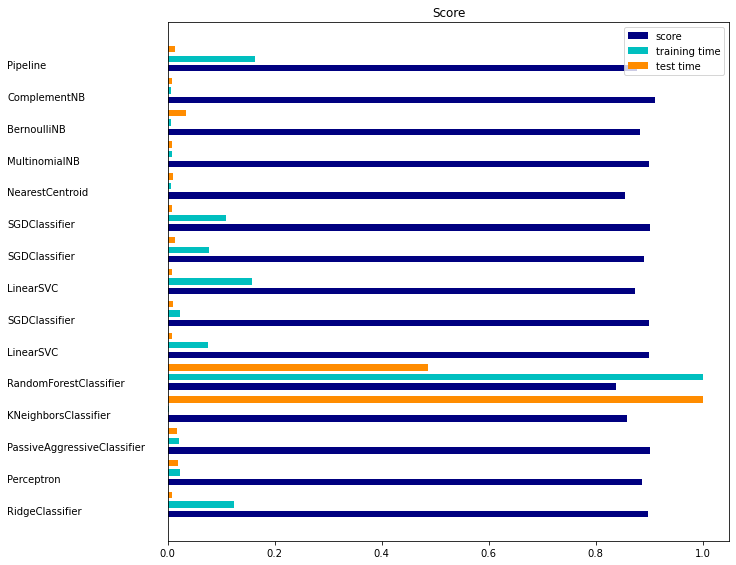

In [36]:
plt.figure(figsize=(12, 8))

plt.title("Score")

plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time", color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')

plt.yticks(())
plt.legend(loc='best')

plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()